In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [33]:
## ~~~~~ Functions ~~~~~ ##

## Coefficient Results Table ##
def results_df(results_obj, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([results_obj.beta_hat_boots.mean(axis=0), results_obj.result2.params]).transpose()
    coeff_estms.columns = ['Bootstrapped', 'Full_Sample']
    coeff_estms['True_Coeffs'] = true_coeffs
    return coeff_estms

def results_df2(big_bootstrap_res, small_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0)), list(small_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap', 'Bootstrap_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

def results_df3(big_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

## Coefficient Estimate Distributions ##
def custom_dist_plots(results_obj, true_coeffs):
    coeff_estms = results_df(results_obj, true_coeffs)
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate\nBlue: Bootstrapped Estimate\nRed: Full Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(results_obj.X_hat.columns.values.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(results_obj.beta_hat_boots[column])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample'][column_index], coeff_estms['Full_Sample'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'red')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.plot([coeff_estms['Bootstrapped'][column_index], coeff_estms['Bootstrapped'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')

def custom_dist_plots2(big_bootstrap_res, results_table_out):
    coeff_estms = results_table_out
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Full Coefficient Estimates\nBlue: Bootstrapped Full Sample Estimate\nRed: Bootstrapped Bootstrap Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(big_bootstrap_res[:,column_index])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.plot([coeff_estms['Bootstrap_Sample_Bootstrap'][column_index], coeff_estms['Bootstrap_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'red')
        plt.title('Coefficient on:   `' + str(column) + '`')
        
        
def custom_dist_plots3(big_bootstrap_res, results_table_out):
    coeff_estms = results_table_out
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Full Coefficient Estimates\nBlue: Bootstrapped Full Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(big_bootstrap_res[:,column_index])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.title('Coefficient on:   `' + str(column) + '`')


## Coefficient Paths ##
def coeff_path_plot(results_obj, var_name, n_boot):
    cumsum_beta_hat_boots = np.cumsum(results_obj.beta_hat_boots[var_name])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));
    
def coeff_path_plot2(big_bootstrap_res, var_name, var_index, n_boot):
    cumsum_beta_hat_boots = np.cumsum(big_bootstrap_res[:, var_index])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));

# Strong Instruments - Double Bootstrap

In [ ]:
np.random.seed(49067)

n = 1500
n_small_bootstrap = 400
n_big_bootstrap = 400

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]



### Big Bootstrap ###
full_sample_btsp_coeff  = np.zeros((n_big_bootstrap, 5))
small_btsp_avg_coeff = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result1 = model1.fit(cov_type='Bootstrap', n_iter = n_small_bootstrap, progress_disable = True)

    ## Results ##
    out_df = results_df(result1, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
    full_sample_btsp_coeff[BB_iter] = out_df['Full_Sample']
    small_btsp_avg_coeff[BB_iter] = out_df['Bootstrapped']

In [5]:
results_table = results_df2(full_sample_btsp_coeff, small_btsp_avg_coeff, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table

,True_Coeffs,Full_Sample_Bootstrap,Bootstrap_Sample_Bootstrap
const,1.5,5.067289,4.899059
endog_hat,2.5,2.902492,3.043898
endog_sq_hat,-0.7,-0.717819,-0.742799
X2,2.0,1.995587,1.995763
X3,3.0,3.003455,3.003368


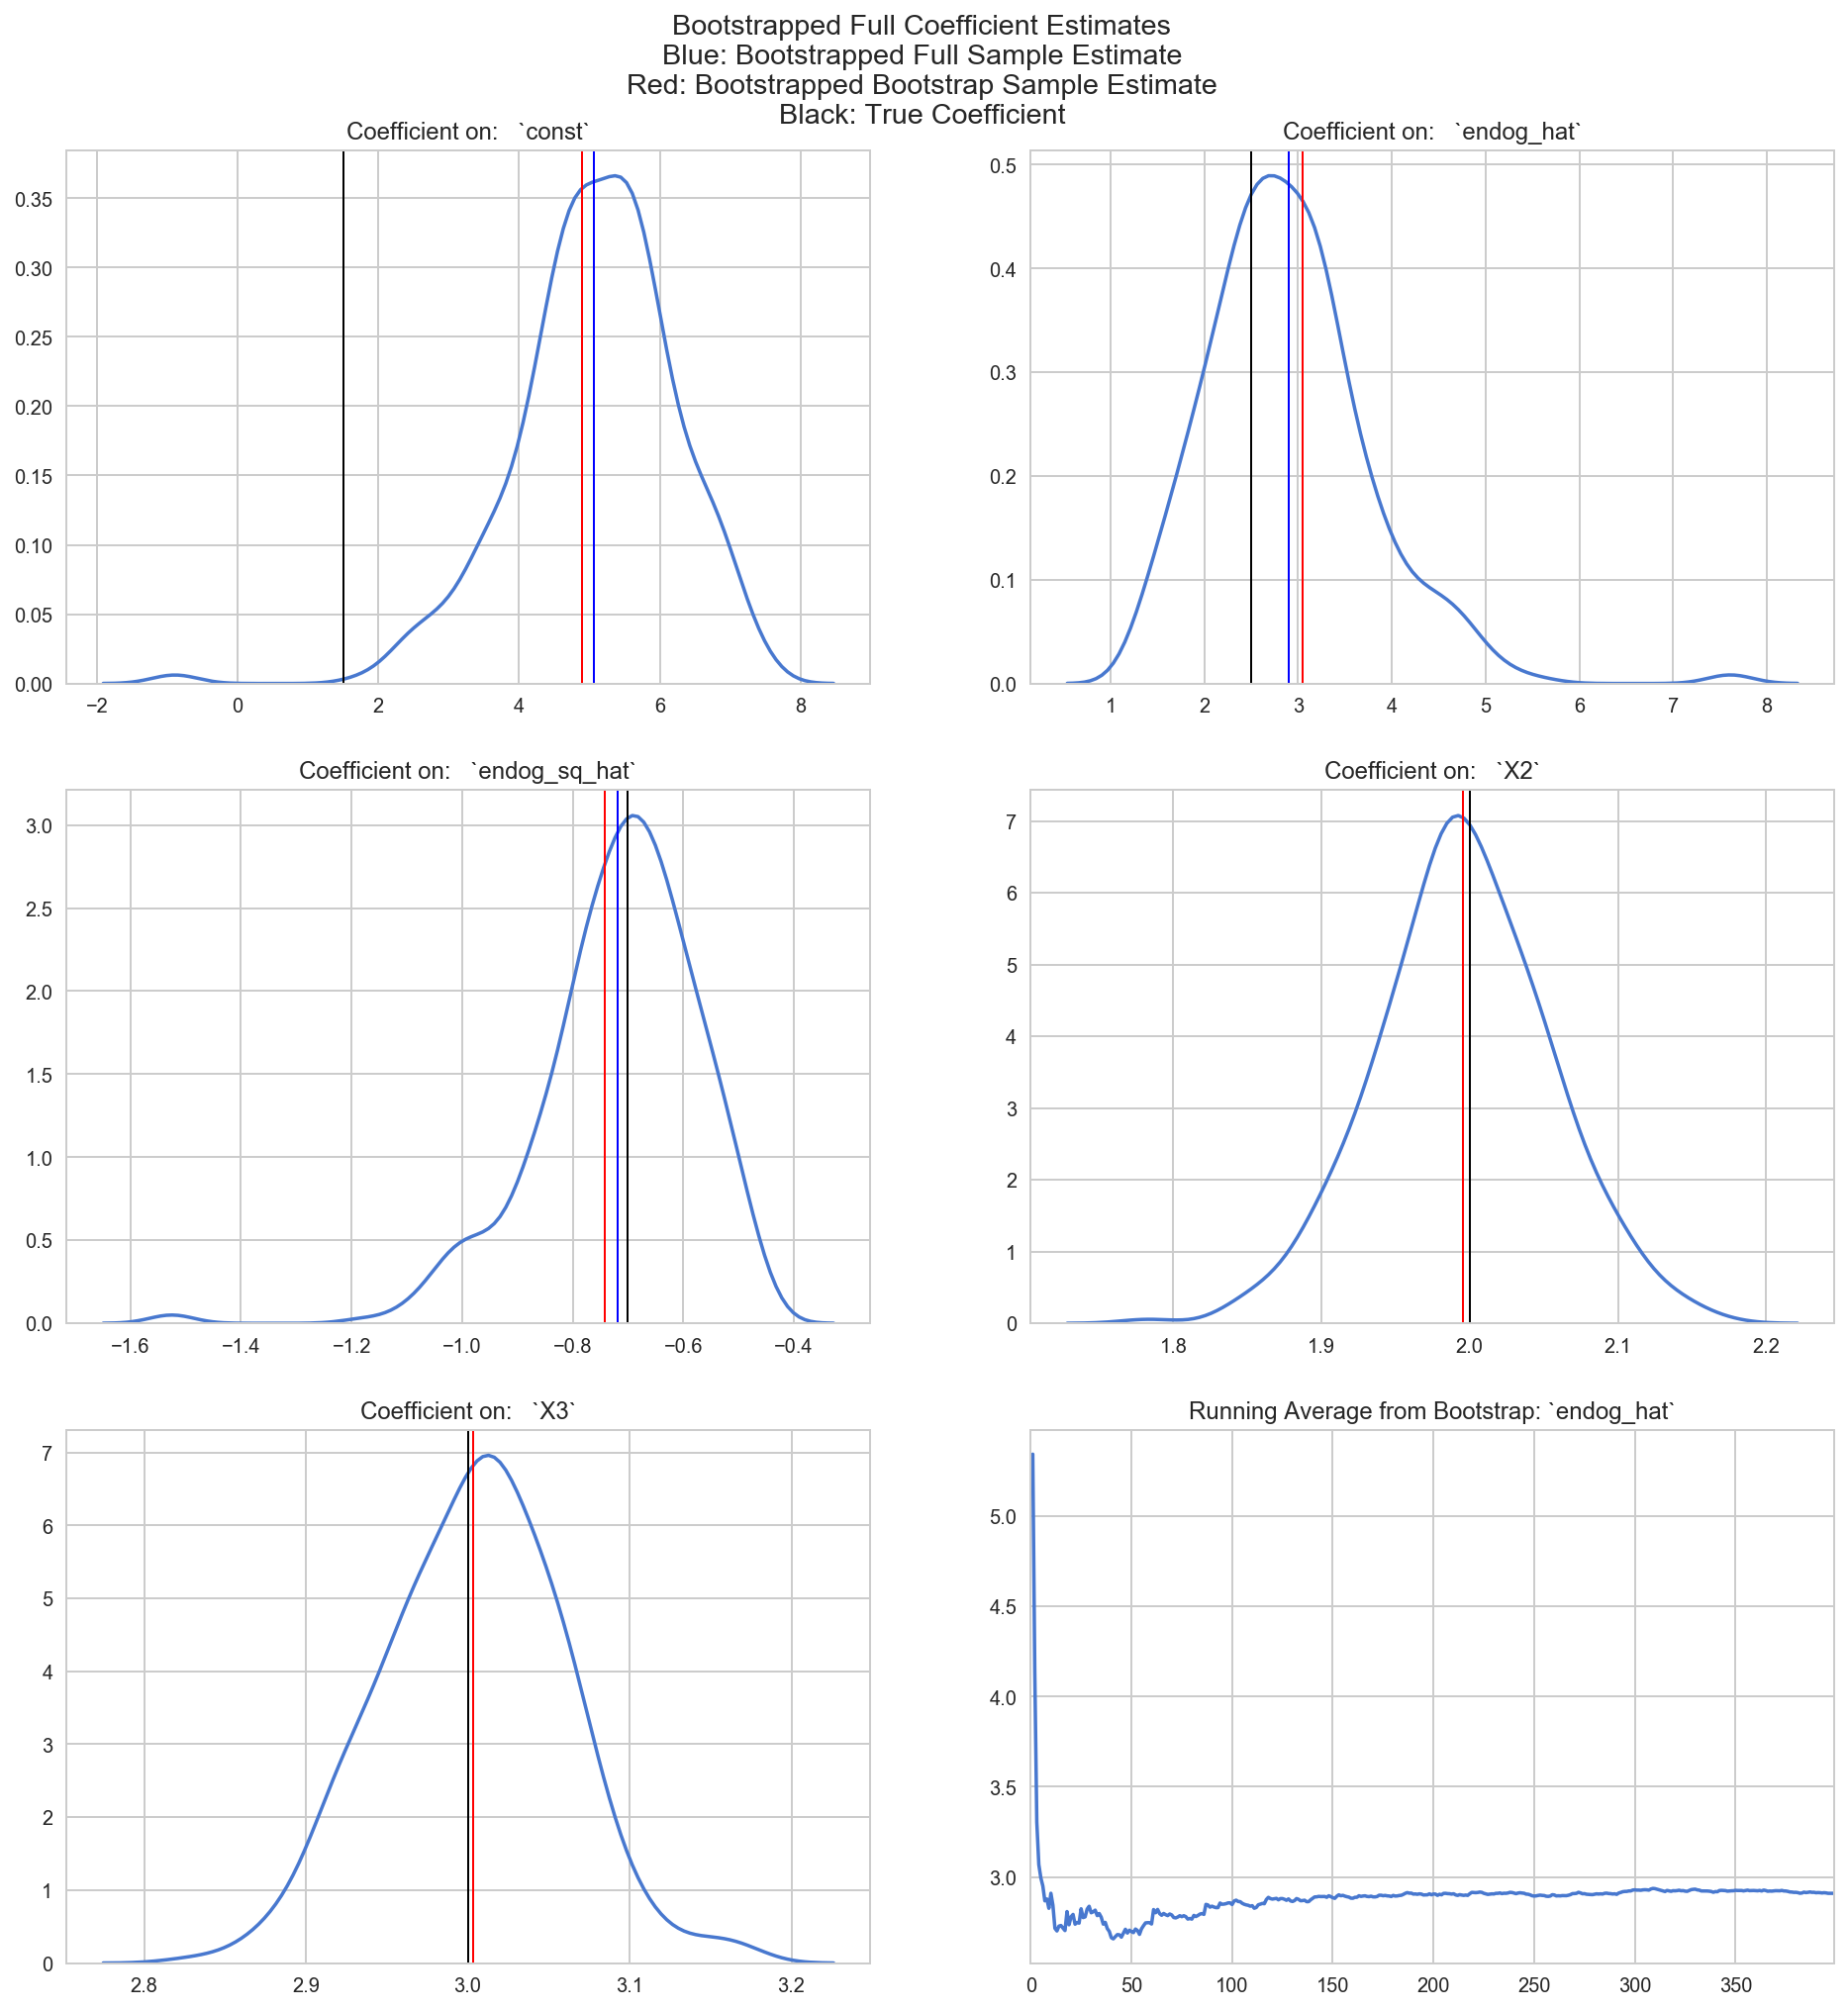

In [32]:
# Full Sample Bootstrap Distributions
custom_dist_plots2(full_sample_btsp_coeff, results_table)
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff, 'endog_hat', 1, n_big_bootstrap)

# Weak Instruments - Double Bootstrap
Note: I'm not going to include the results from the smaller bootstrap because it increases runtime too much and they seem to be fairly close estimates of the full sample coeff estimates

In [37]:
np.random.seed(49067)

n = 1500
n_small_bootstrap = 1
n_big_bootstrap = 400

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]



### Big Bootstrap ###
full_sample_btsp_coeff  = np.zeros((n_big_bootstrap, 5))
small_btsp_avg_coeff = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result1 = model1.fit(cov_type='Bootstrap', n_iter = n_small_bootstrap, progress_disable = True)

    ## Results ##
    out_df = results_df(result1, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
    full_sample_btsp_coeff[BB_iter] = out_df['Full_Sample']
    small_btsp_avg_coeff[BB_iter] = out_df['Bootstrapped']

100%|██████████| 400/400 [00:08<00:00, 47.00it/s]


In [39]:
results_table = results_df3(full_sample_btsp_coeff, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,7.579089
endog_hat,2.5,1.389009
endog_sq_hat,-0.7,-0.514743
X2,2.0,1.992839
X3,3.0,2.996458


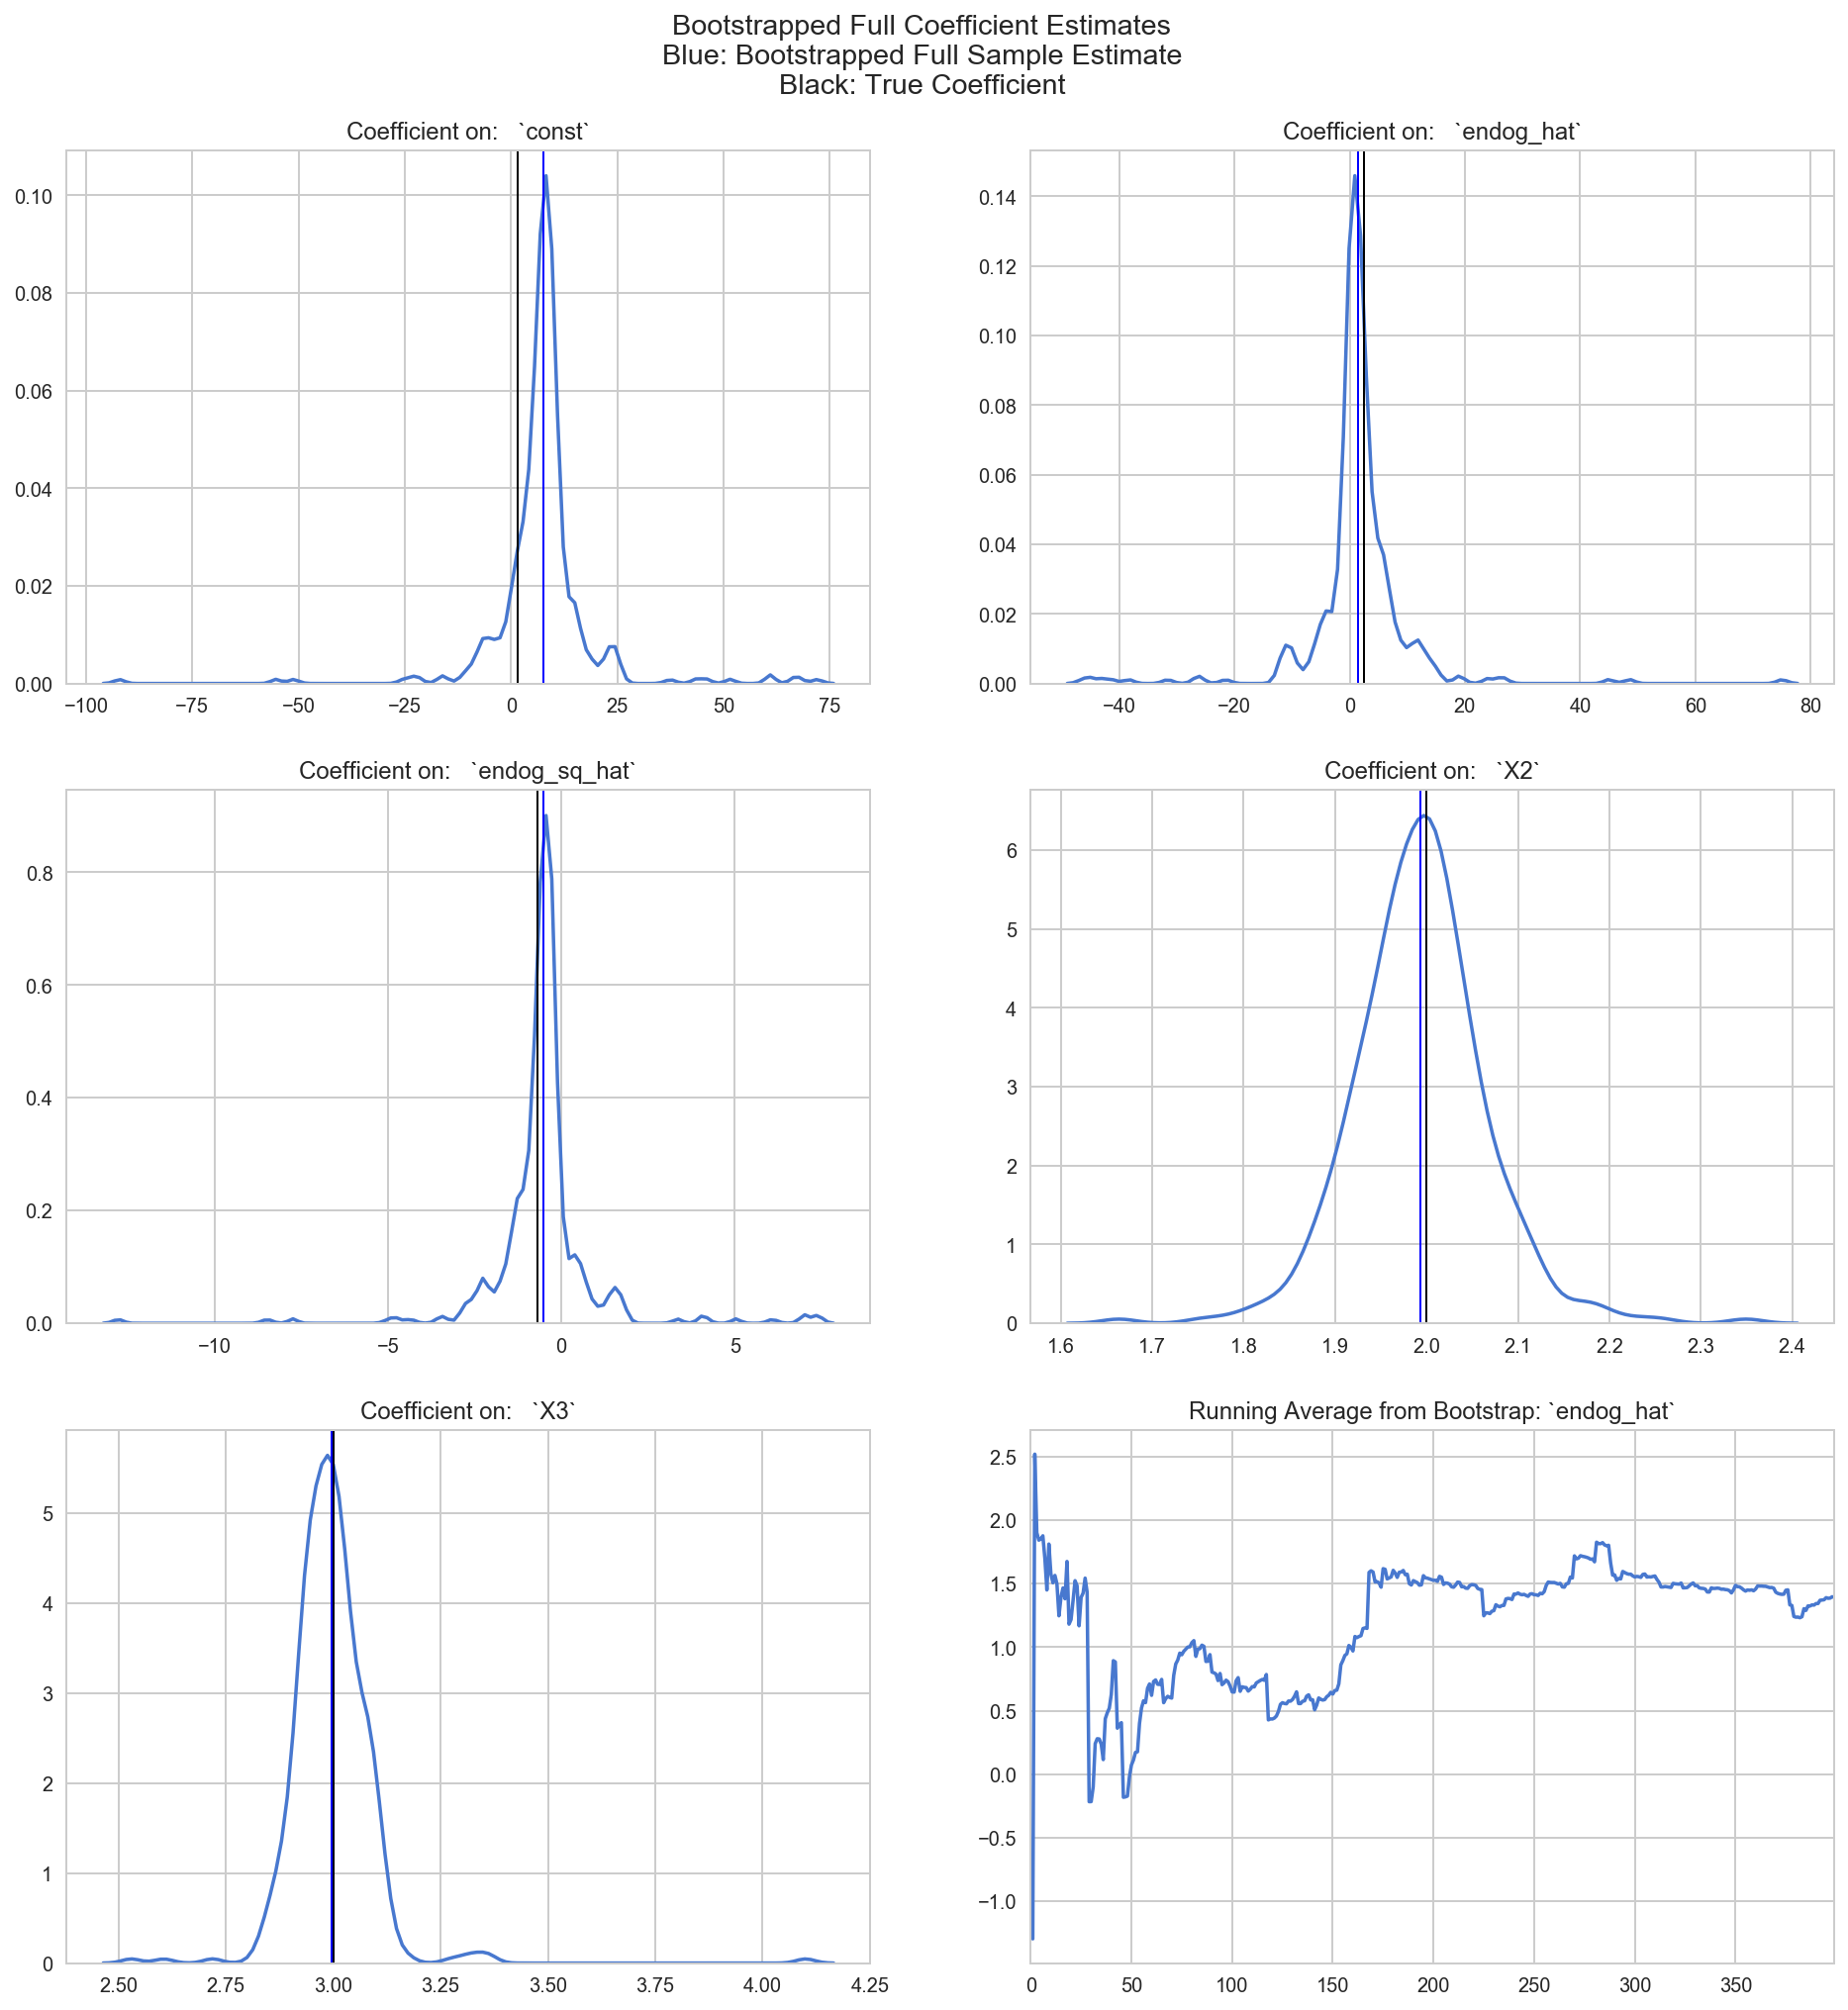

In [41]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff, results_table)
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff, 'endog_hat', 1, n_big_bootstrap)